 ### **Maleria Dignosis**

### **Task** : Correctly classifying wheather an input cell contains maleria parasite or not.

In [75]:
# Importing libraris

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [76]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
 

In [77]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [78]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/yash/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood sme

In [79]:
def splits(dataset, Train_ratio, val_ratio, test_ratio):
    dataset_size = len(dataset)

    train_dataset = dataset.take(int(Train_ratio*dataset_size))

    val_test_dataset = dataset.skip(int(Train_ratio*dataset_size))
    val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))

    test_datset = val_test_dataset.skip(int(val_ratio*dataset_size))

    return train_dataset, val_dataset, test_datset


In [80]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], train_ratio, val_ratio, test_ratio)


In [81]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

### Data Visualization

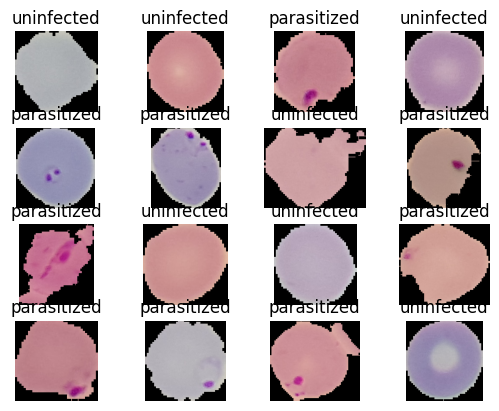

In [82]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [83]:
dataset_info.features['label'].int2str(1)

'uninfected'

### Data Preprocessing

In [84]:
IM_SIZE = 224

def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [85]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)


In [86]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [87]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


### Sequential API

In [88]:
model = tf.keras.Sequential()

model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

model.add(Conv2D(filters = 6, kernel_size=3, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters = 16, kernel_size=3, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(10, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation = 'sigmoid'))

model.summary()


In [92]:
model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics='accuracy')

In [93]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, verbose=1)

Epoch 1/15
689/689 [==============================] - 63s 86ms/step - loss: 0.5907 - accuracy: 0.6835 - val_loss: 1.0972 - val_accuracy: 0.4958
Epoch 2/15
689/689 [==============================] - 55s 79ms/step - loss: 0.5089 - accuracy: 0.7456 - val_loss: 8.6348 - val_accuracy: 0.5042
Epoch 3/15
689/689 [==============================] - 53s 77ms/step - loss: 0.2310 - accuracy: 0.9165 - val_loss: 0.4367 - val_accuracy: 0.8907
Epoch 4/15
689/689 [==============================] - 53s 76ms/step - loss: 0.2010 - accuracy: 0.9298 - val_loss: 0.7264 - val_accuracy: 0.4933
Epoch 5/15
689/689 [==============================] - 55s 80ms/step - loss: 0.1966 - accuracy: 0.9354 - val_loss: 0.3018 - val_accuracy: 0.9263
Epoch 6/15
689/689 [==============================] - 55s 80ms/step - loss: 0.1959 - accuracy: 0.9350 - val_loss: 0.1874 - val_accuracy: 0.9412
Epoch 7/15
689/689 [==============================] - 56s 81ms/step - loss: 0.1670 - accuracy: 0.9477 - val_loss: 0.1449 - val_accuracy:

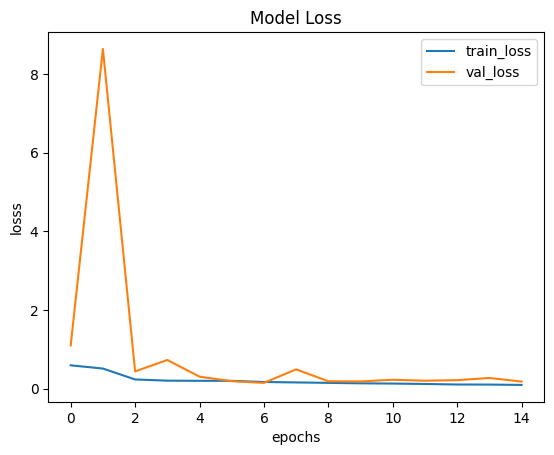

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('losss')
plt.xlabel('epochs')
plt.legend(['train_loss', 'val_loss'])
plt.show()

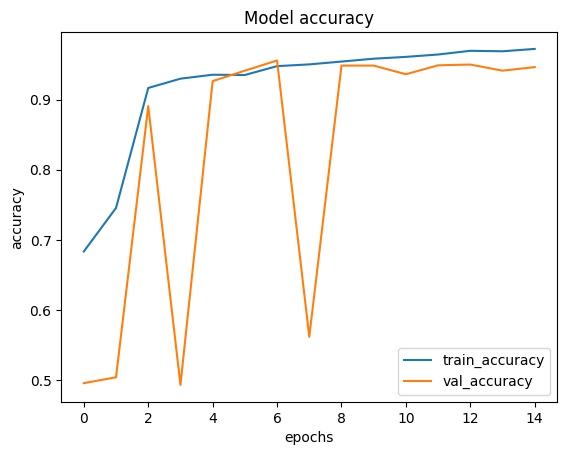

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Model Evaluation and Testing

In [96]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [97]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [98]:
# tf.config.run_functions_eagerly(True)
model.evaluate(test_dataset)

2757/2757 [==============================] - 44s 15ms/step - loss: 0.2142 - accuracy: 0.9391


[0.21421745419502258, 0.9390642046928406]

In [99]:
def parasite_or_not(x):
    if (x < 0.5):
        return str('P')
    else:
        return str('U')

In [100]:
parasite_or_not(model.predict(test_dataset.take(1)))

1/1 [==============================] - 1s 1s/step


'U'

1/1 [==============================] - 0s 22ms/step


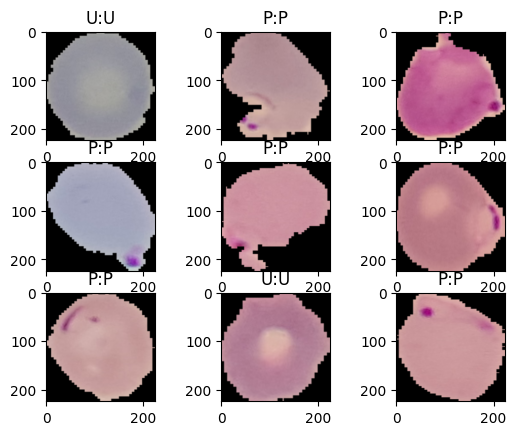

In [101]:
for i, (image, label) in enumerate(test_dataset.take(9)):

    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

In [102]:
# All the paramameters which are used to build this model are known as model configuration.
# So there are two ways of saving model one is to save full model i.e. weight and configuration and other is to save only weights 
# But for using model to make prediction we need both weights and configuration 

In [104]:
# methods for saving model

model.save('lenet.hdf5')

/home/yash/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [105]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 46656)             0         
                                                                 
 dense_11 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_25 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 10)                

In [ ]:
# # Another type of saving model 
# # Saving only weights

# model.save_weights("weights/lenet_weights")

In [ ]:
# lenet_weights_model = model.load_weights("weights/lenet_weights")